<a href="https://colab.research.google.com/github/aminmh/ml/blob/main/Intel_Image_Classification_(CNN_Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle

In [3]:
#!/bin/bash
!kaggle datasets download puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 93% 323M/346M [00:00<00:00, 1.69GB/s]
100% 346M/346M [00:00<00:00, 1.69GB/s]


In [4]:
!unzip -qq intel-image-classification.zip

In [5]:
import os, shutil

In [6]:
for directory in os.listdir('seg_test/seg_test'):
  shutil.move('seg_test/seg_test/' + directory, 'seg_test')

shutil.rmtree('seg_test/seg_test')

In [7]:
for directory in os.listdir('seg_train/seg_train'):
  shutil.move('seg_train/seg_train/' + directory, 'seg_train')

shutil.rmtree('seg_train/seg_train')

In [8]:
from glob import glob

print (f"size of training: {len(glob('seg_train/*/*.jpg'))}")
print (f"size of training: {len(glob('seg_test/*/*.jpg'))}")

size of training: 14034
size of training: 3000


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [10]:
train_dir = 'seg_train'
test_dir = 'seg_test'
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

In [11]:
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [12]:
validation_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [13]:
class_names = train_dataset.class_names
print(f"all recognize classes: {class_names}")

all recognize classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


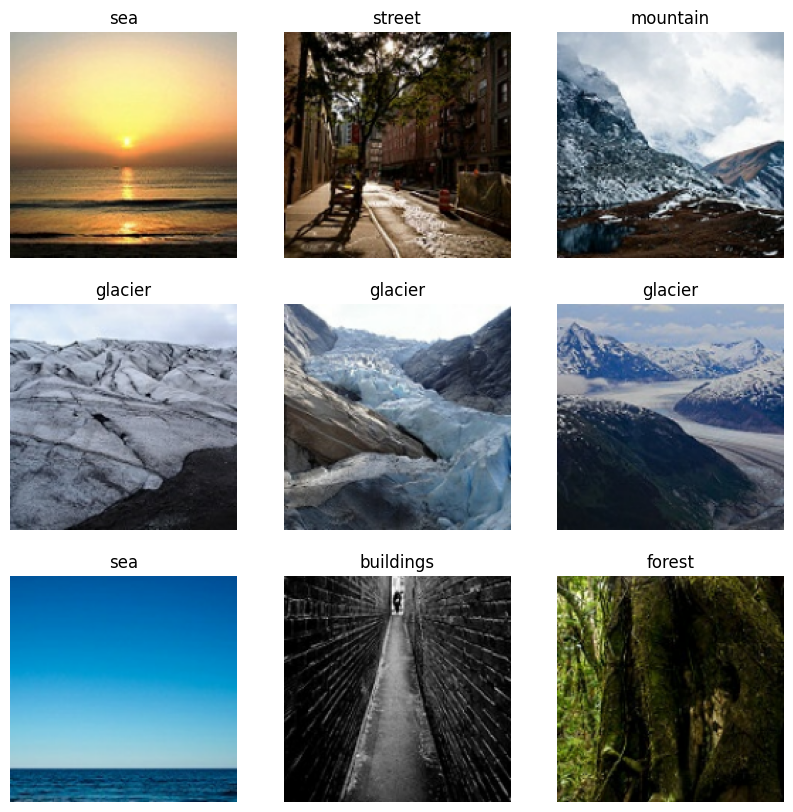

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    # Convert one-hot encoded label to integer index
    predicted_class_index = tf.argmax(labels[i]).numpy()
    plt.title(class_names[predicted_class_index])
    plt.axis('off')

In [15]:
scaling_layer = layers.Rescaling(1./ 255)

In [16]:
import numpy as np

In [17]:
scaled_train_dataset = train_dataset.map(lambda x, y: (scaling_layer(x), y))
scaled_images_batch, _ = next(iter(scaled_train_dataset))
print(f"min image pixel value: {np.min(scaled_images_batch[4]): .2f}")
print(f"max image pixel value: {np.max(scaled_images_batch[4]): .2f}")

min image pixel value:  0.00
max image pixel value:  0.90


In [18]:
test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical'
)

Found 3000 files belonging to 6 classes.


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
data_agumentation = keras.Sequential([
    scaling_layer,
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2, fill_mode='nearest'),
    layers.RandomZoom(0.2, fill_mode='nearest'),
])

In [39]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [40]:
inception_model = InceptionV3(
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    weights='imagenet',
    classes=len(class_names)
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [41]:
inception_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 79, 79,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 79, 79,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 79, 79,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 77, 77,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 77, 77,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 38, 38,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 36, 36,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 36, 36,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [42]:
inception_model.trainable = False

In [43]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_agumentation(inputs)
x = preprocess_input(x)
x = inception_model(x, training=False)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [44]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,110 (91.20 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [46]:
learning_rate = 0.0001
model.compile(
    keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
history = model.fit(train_dataset, epochs=15, validation_data=validation_dataset)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.3304 - loss: 1.6208 - val_accuracy: 0.4868 - val_loss: 1.3470
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4560 - loss: 1.3778 - val_accuracy: 0.5146 - val_loss: 1.2654
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4799 - loss: 1.3183 - val_accuracy: 0.5388 - val_loss: 1.2217
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4898 - loss: 1.2894 - val_accuracy: 0.5406 - val_loss: 1.2100
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4977 - loss: 1.2697 - val_accuracy: 0.5435 - val_loss: 1.1876
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5100 - loss: 1.2471 - val_accuracy: 0.5567 - val_loss: 1.1667
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5179 - loss: 1.2326 - val_accuracy: 0.5595 - val_loss: 1.1653
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5132 - loss: 1.2308 - val_acc

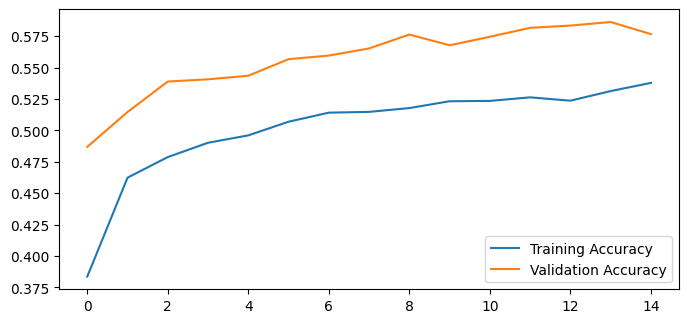

In [48]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()